<a href="https://colab.research.google.com/github/Kaidavid/CS492A_Courseworks/blob/master/Coursework1_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive, files

drive.mount('/gdrive')
# Specify the directory path where `Coursework_1.ipynb` exists.
# then set root = '/gdrive/My Drive/CS492A'

root = '/gdrive/My Drive/CS492A'
#!ls /gdrive/MyDrive/CS492A

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Import Libraries

In [ ]:
import os, re
import random
import scipy.io
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

### Test and Train Data

In [ ]:
class CREATE_YOUR_OWN():
  def __init__(self, num_class=10, total_size=30, test_size=15):
    self.num_class = num_class
    self.total_size = total_size
    self.test_size = test_size
    self.train_size = total_size - test_size
  
  def create_classes(self):
    categories = os.listdir(root + '/101_ObjectCategories')
    rand_categories = random.sample(categories, len(categories))
    classes = []
    while len(classes) < self.num_class and len(rand_categories) != 0:
      category = rand_categories[0]
      if len(os.listdir(root + '/101_ObjectCategories/' + category)) >= self.total_size:
        classes.append(category)
        rand_categories.pop(0)
      else:
        rand_categories.pop(0)

    if len(rand_categories) == 0:
      print(f"Only {len(classes)} classes have {self.total_size} train-test data")
      return classes
    else:
      return classes
  
  def train_test_split(self):
    train_images, train_labels, test_images, test_labels = [], [], [], []
    classes = self.create_classes()
    for i in range(len(classes)):
      class_i = os.listdir(root + '/101_ObjectCategories/' + classes[i])  #from the 10 classes, pick 1, and get images within it
      random_total_size = random.sample(range(0, len(class_i)), self.total_size)   #only pick 30 images
      random_total_size.sort()
      for j in range(self.train_size):
        train_images.append(os.path.join(root, '101_ObjectCategories', classes[i], class_i[random_total_size[j]]))
        train_labels.append(classes[i])
      for j in range(self.train_size, self.total_size):
        test_images.append(os.path.join(root, '101_ObjectCategories', classes[i], class_i[random_total_size[j]]))
        test_labels.append(classes[i])
    return train_images, train_labels, test_images, test_labels

In [ ]:
our_own_classes = CREATE_YOUR_OWN(20, 800, 30)
train_images, train_labels, test_images, test_labels = our_own_classes.train_test_split()

Only 1 classes have 800 train-test data


### On already given classes

In [ ]:
classes = ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel']
mat_vocab = scipy.io.loadmat(root + '/tiny-vocab.mat')
mat_descr_train  = scipy.io.loadmat(root + '/tiny-descrs_train_all.mat')
mat_descr_test  = scipy.io.loadmat(root + '/tiny-descrs_test_all.mat')

X = list(mat_vocab.values())[3]   # vocabulary words built from training data
Y = list(mat_descr_train.values())[3]   # each descriptor train
Z = list(mat_descr_test.values())[3]   # each descriptor test

In [ ]:
def quantize_descr(vocab, descrs, K=3):   # quantization of images to get its visual words
  quantized_pics = []   
  for i in range(descrs.shape[1]):     # descrs.shape[1] = number of train or test images
    img = descrs[0, i]     # 128x??? descriptors
    hist_y = np.zeros(vocab.shape[1])
    # Find the descriptor that is closest to one of the codewords and +1 to it
    for i in range(vocab.shape[1]):   # 128x300 codewords
      for j in range(img.shape[1]):   # for each descriptors
        # L1_distance = np.sum(np.abs(vocab - img[:, j].reshape(-1,1)), axis = 0)
        # min_dist_index = np.argmin(L1_distance)
        L2_distance = np.sum(np.square(vocab - img[:, j].reshape(-1,1)), axis = 0)
        # min_dist_index = np.argmin(L2_distance)
        # hist_y[min_dist_index] += 1
        min_dist_indices = np.argsort(L2_distance)      # +1 to KNNs
        for k in range(K):
          hist_y[min_dist_indices[k]] += 1
    quantized_pics.append(hist_y)
  return quantized_pics

In [ ]:
quantized = quantize_descr(X, Z)    # vectorizing this function is crucial as it takes ~2hrs
np_arr = np.array(quantized)   #change list to numpy array
df = pd.DataFrame(np_arr)
df.to_csv("transformed_test_data_K3.csv", index=False)
files.download("transformed_test_data_K3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [507]:
def train_test_split(Images):
  train_images, train_labels, test_images, test_labels = [], [], [], []
  for i in range(0, 20, 2):
    j = i+1
    for x in range(i*15, j*15):
      train_images.append(os.path.join(root, '101_ObjectCategories', re.sub(r'\\', '/', Images[0, x][0])))
      train_labels.append(Images[0, x][0].split('\\')[0])
    for x in range(j*15, (j+1)*15):
      test_images.append(os.path.join(root, '101_ObjectCategories', re.sub(r'\\', '/', Images[0, x][0])))
      test_labels.append(Images[0, x][0].split('\\')[0])
  return train_images, train_labels, test_images, test_labels

In [545]:
train_images, train_labels, test_images, test_labels = train_test_split(Images)
train_data_k1 = pd.read_csv(root + "/transformed_train_data_K1.csv")
test_data_k1 = pd.read_csv(root + "/transformed_test_data_K1.csv")
train_data_k3 = pd.read_csv(root + "/transformed_train_data_K3.csv")
test_data_k3 = pd.read_csv(root + "/transformed_test_data_K3.csv")
train_data_k1['label'] = train_labels
test_data_k1['label'] = test_labels
train_data_k3['label'] = train_labels
test_data_k3['label'] = test_labels
# Randomize train and test data
train_data_shuffled_k1 = train_data_k1.sample(frac=1)
test_data_shuffled_k1 = test_data_k1.sample(frac=1)
train_data_shuffled_k3 = train_data_k3.sample(frac=1)
test_data_shuffled_k3 = test_data_k3.sample(frac=1)

### Visualize images

In [515]:
## Sample bagged words for K = 1
fig1 = make_subplots(rows=2, cols=2, subplot_titles=['K=1, BACKGROUND_Google', 'K=1, Leopards', 'K=1, Motorbikes', 'K=1, accordion'])
fig1.add_trace(go.Bar(x=np.arange(300), y=train_data_k1.iloc[0,:-1]), row=1, col=1)
fig1.add_trace(go.Bar(x=np.arange(300), y=train_data_k1.iloc[45,:-1]), row=1, col=2)
fig1.add_trace(go.Bar(x=np.arange(300), y=train_data_k1.iloc[60,:-1]), row=2, col=1)
fig1.add_trace(go.Bar(x=np.arange(300), y=train_data_k1.iloc[75,:-1]), row=2, col=2)
fig1.update_layout(showlegend=False)
fig1.show()

In [514]:
## Sample bagged words for K = 3
fig2 = make_subplots(rows=2, cols=2, subplot_titles=['K=3, BACKGROUND_Google', 'K=3, Leopards', 'K=3, Motorbikes', 'K=3, accordion'])
fig2.add_trace(go.Bar(x=np.arange(300), y=train_data_k3.iloc[0,:-1]), row=1, col=1)
fig2.add_trace(go.Bar(x=np.arange(300), y=train_data_k3.iloc[45,:-1]), row=1, col=2)
fig2.add_trace(go.Bar(x=np.arange(300), y=train_data_k3.iloc[60,:-1]), row=2, col=1)
fig2.add_trace(go.Bar(x=np.arange(300), y=train_data_k3.iloc[75,:-1]), row=2, col=2)
fig2.update_layout(showlegend=False)
fig2.show()

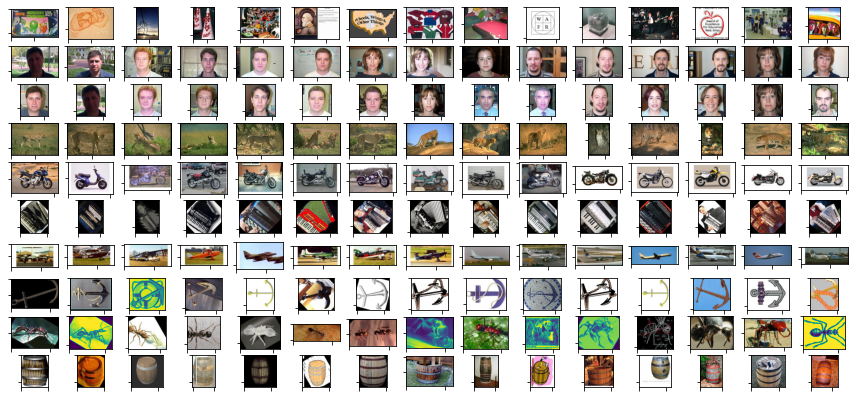

In [ ]:
## All training images
_ , axes = plt.subplots(10, 15, figsize=(15, 7))
for i, ax in enumerate(axes.flat):
  ax.imshow(mpimg.imread(train_images[i]))
  ax.set_yticklabels([])
  ax.set_xticklabels([])

### Build bar graphs of an image from its descriptors

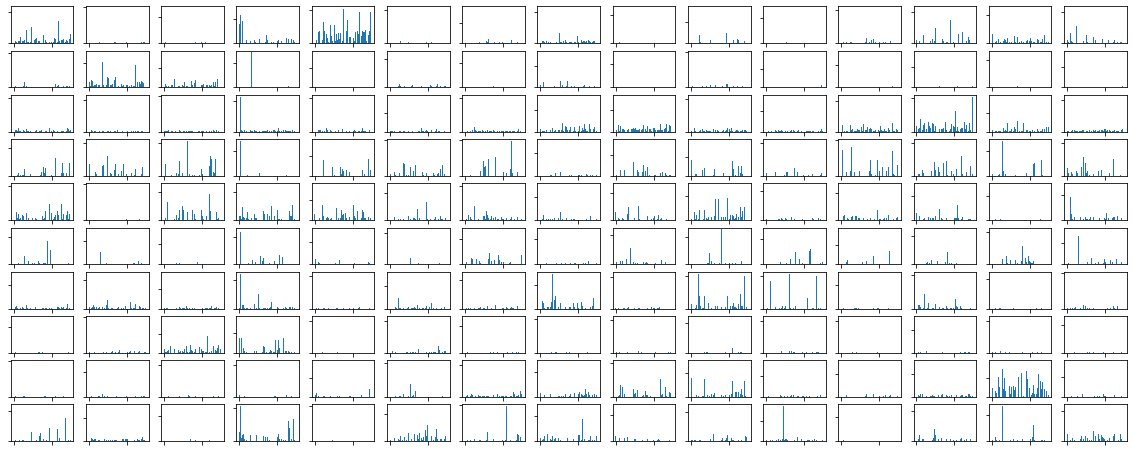

In [660]:
## All visual words for K = 1
_ , axes = plt.subplots(10, 15, figsize=(20, 8))
for i, ax in enumerate(axes.flat):
  ax.bar(np.arange(300), train_data_k1.iloc[i,:300])
  ax.set_yticklabels([])
  ax.set_xticklabels([])

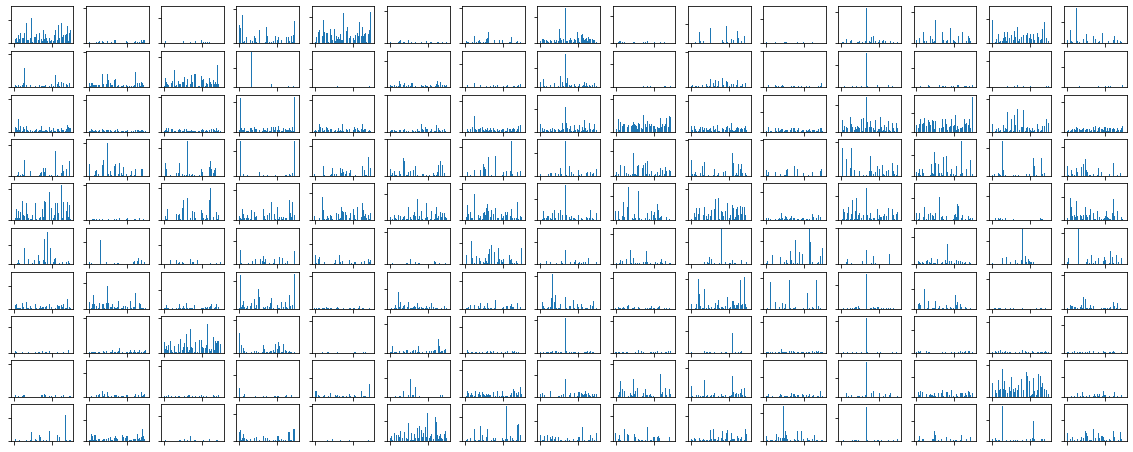

In [516]:
## All visual words for K = 3
_ , axes = plt.subplots(10, 15, figsize=(20, 8))
for i, ax in enumerate(axes.flat):
  ax.bar(np.arange(300), train_data_k3.iloc[i,:300])
  ax.set_yticklabels([])
  ax.set_xticklabels([])

### Random Forest K = 1

In [631]:
X_train_k1 = train_data_k1.iloc[:,:300]
X_test_k1 = test_data_k1.iloc[:,:300]
y_train_k1 = train_data_k1.iloc[:,-1:].values.ravel()
y_test_k1 = test_data_k1.iloc[:,-1:].values.ravel()

scaler_k1 = StandardScaler().fit(X_train_k1)      #standardize the dataset with X_train after splitting to avoid data leakage
X_train_k1, X_test_k1 = scaler_k1.transform(X_train_k1), scaler_k1.transform(X_test_k1)       #tranform the test with the scaler from the train set

RF_k1 = RandomForestClassifier(n_estimators = 16, criterion='entropy', max_depth = 7, min_samples_split = 4, random_state = 42)
RF_k1.fit(X_train_k1, y_train_k1)

y_predicted_k1 = RF_k1.predict(X_test_k1)
print("Accuracy RF: {}%\n".format(round(accuracy_score(y_test_k1, y_predicted_k1)*100, 1)))
print(classification_report(y_test_k1, y_predicted_k1, target_names=classes))

Accuracy RF: 67.3%

                   precision    recall  f1-score   support

BACKGROUND_Google       0.50      0.33      0.40        15
            Faces       0.75      0.80      0.77        15
       Faces_easy       0.74      0.93      0.82        15
         Leopards       0.79      1.00      0.88        15
       Motorbikes       0.65      0.87      0.74        15
        accordion       0.94      1.00      0.97        15
        airplanes       0.65      0.87      0.74        15
           anchor       0.33      0.13      0.19        15
              ant       0.53      0.53      0.53        15
           barrel       0.44      0.27      0.33        15

         accuracy                           0.67       150
        macro avg       0.63      0.67      0.64       150
     weighted avg       0.63      0.67      0.64       150



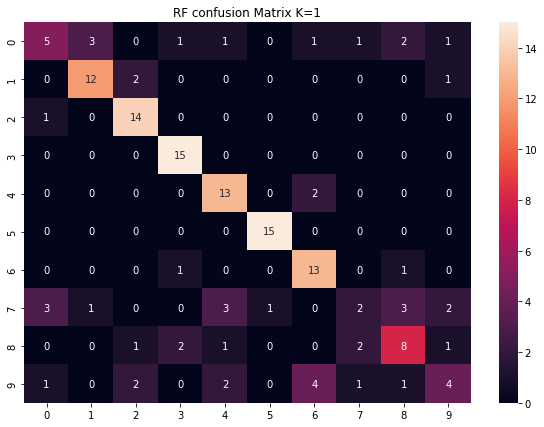

In [592]:
confusion_matrix_k1 = confusion_matrix(y_test_k1, y_predicted_k1)
plt.subplots(figsize=(10,7))
plt.title("RF confusion Matrix K=1")
sns.heatmap(confusion_matrix_k1, annot=True)

### Support Vector Machine Classifier K = 1

In [634]:
#Create a svm Classifier
svm_k1 = SVC(C=10, kernel='rbf', gamma=0.001) # Linear Kernel
svm_k1.fit(X_train_k1, y_train_k1)
y_pred_k1 = svm_k1.predict(X_test_k1)
print("Accuracy SVM: {}%\n".format(round(accuracy_score(y_test_k1, y_pred_k1)*100, 1)))
print(classification_report(y_test_k1, y_pred_k1, target_names=classes))

Accuracy SVM: 76.0%

                   precision    recall  f1-score   support

BACKGROUND_Google       0.75      0.60      0.67        15
            Faces       0.87      0.87      0.87        15
       Faces_easy       0.70      0.93      0.80        15
         Leopards       0.94      1.00      0.97        15
       Motorbikes       0.65      1.00      0.79        15
        accordion       1.00      0.80      0.89        15
        airplanes       0.83      1.00      0.91        15
           anchor       0.40      0.13      0.20        15
              ant       0.58      0.73      0.65        15
           barrel       0.80      0.53      0.64        15

         accuracy                           0.76       150
        macro avg       0.75      0.76      0.74       150
     weighted avg       0.75      0.76      0.74       150



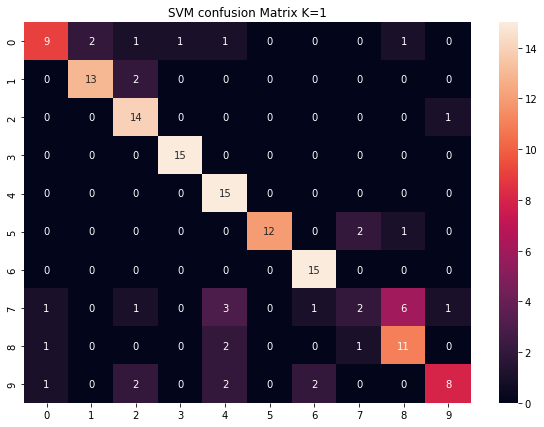

In [594]:
confusion_mat_k1 = confusion_matrix(y_test_k1, y_pred_k1)
plt.subplots(figsize=(10,7))
plt.title("SVM confusion Matrix K=1")
sns.heatmap(confusion_mat_k1, annot=True)

### Wrong Classifications K = 1

In [658]:
# Anchor has the lowest precision in RF
outputs_k1 = pd.DataFrame(np.hstack((y_test_k1.reshape(-1,1), y_predicted_k1.reshape(-1,1))))
FP_FN_anchor_k1 = outputs_k1[(outputs_k1.iloc[:,0] == "anchor") & (outputs_k1.iloc[:,1] != "anchor")]
FP_FN_anchor_k1

,0,1
105,anchor,Motorbikes
107,anchor,Faces
109,anchor,BACKGROUND_Google
110,anchor,BACKGROUND_Google
111,anchor,ant
112,anchor,barrel
113,anchor,Motorbikes
114,anchor,BACKGROUND_Google
115,anchor,accordion
116,anchor,barrel


### Random Forest K = 3

In [653]:
X_train_k3 = train_data_k3.iloc[:,:300]
X_test_k3 = test_data_k3.iloc[:,:300]
y_train_k3 = train_data_k3.iloc[:,-1:].values.ravel()
y_test_k3 = test_data_k3.iloc[:,-1:].values.ravel()

scaler_k3 = StandardScaler().fit(X_train_k3)      #standardize the dataset with X_train after splitting to avoid data leakage
X_train_k3, X_test_k3 = scaler_k3.transform(X_train_k3), scaler_k3.transform(X_test_k3)       #tranform the test with the scaler from the train set

RF_k3 = RandomForestClassifier(n_estimators = 15, criterion='entropy', max_depth = 8, min_samples_split = 3, random_state = 42)
RF_k3.fit(X_train_k3, y_train_k3)

y_predicted_k3 = RF_k3.predict(X_test_k3)
print("Accuracy RF: {}%\n".format(round(accuracy_score(y_test_k3, y_predicted_k3)*100, 1)))
print(classification_report(y_test_k3, y_predicted_k3, target_names=classes))

Accuracy RF: 73.3%

                   precision    recall  f1-score   support

BACKGROUND_Google       0.88      0.47      0.61        15
            Faces       0.92      0.73      0.81        15
       Faces_easy       0.61      0.93      0.74        15
         Leopards       0.83      1.00      0.91        15
       Motorbikes       0.68      0.87      0.76        15
        accordion       1.00      1.00      1.00        15
        airplanes       0.75      1.00      0.86        15
           anchor       0.50      0.13      0.21        15
              ant       0.59      0.67      0.62        15
           barrel       0.57      0.53      0.55        15

         accuracy                           0.73       150
        macro avg       0.73      0.73      0.71       150
     weighted avg       0.73      0.73      0.71       150



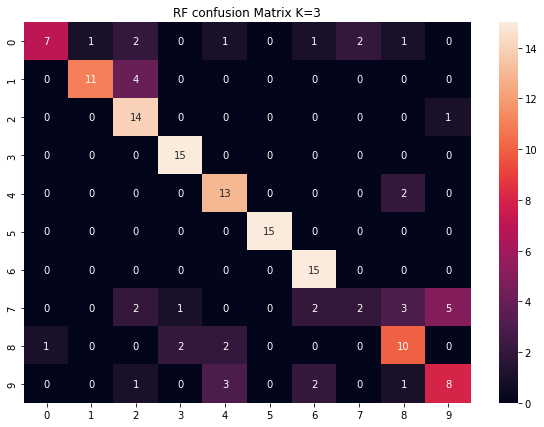

In [633]:
confusion_matrix_k3 = confusion_matrix(y_test_k3, y_predicted_k3)
plt.subplots(figsize=(10,7))
plt.title("RF confusion Matrix K=3")
sns.heatmap(confusion_matrix_k3, annot=True)

### Support Vector Machine Classifier K = 3

In [650]:
#Create a svm Classifier
svm_k3 = SVC(C=100, kernel='rbf', gamma=0.001) # Linear Kernel
svm_k3.fit(X_train_k3, y_train_k3)
y_pred_k3 = svm_k3.predict(X_test_k3)
print("Accuracy SVM: {}%\n".format(round(accuracy_score(y_test_k3, y_pred_k3)*100, 1)))
print(classification_report(y_test_k3, y_pred_k3, target_names=classes))

Accuracy SVM: 77.3%

                   precision    recall  f1-score   support

BACKGROUND_Google       0.85      0.73      0.79        15
            Faces       0.94      1.00      0.97        15
       Faces_easy       0.70      0.93      0.80        15
         Leopards       0.88      1.00      0.94        15
       Motorbikes       0.68      0.87      0.76        15
        accordion       1.00      0.87      0.93        15
        airplanes       0.74      0.93      0.82        15
           anchor       0.25      0.07      0.11        15
              ant       0.63      0.80      0.71        15
           barrel       0.80      0.53      0.64        15

         accuracy                           0.77       150
        macro avg       0.75      0.77      0.75       150
     weighted avg       0.75      0.77      0.75       150



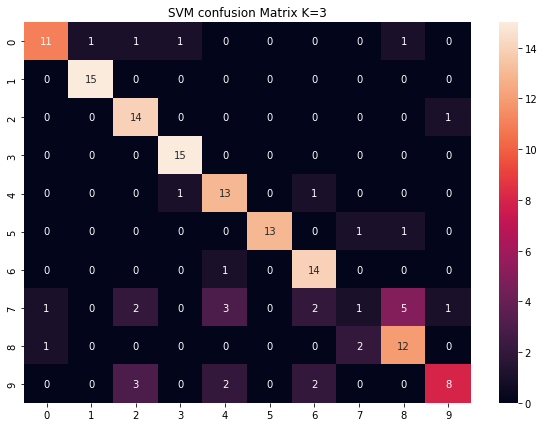

In [651]:
confusion_mat_k3 = confusion_matrix(y_test_k3, y_pred_k3)
plt.subplots(figsize=(10,7))
plt.title("SVM confusion Matrix K=3")
sns.heatmap(confusion_mat_k3, annot=True)

### Wrong Classifications

In [659]:
# Anchor has the lowest precision
outputs_k3 = pd.DataFrame(np.hstack((y_test_k3.reshape(-1,1), y_predicted_k3.reshape(-1,1))))
FP_FN_anchor_k3 = outputs_k3[(outputs_k3.iloc[:,0] == "anchor") & (outputs_k3.iloc[:,1] != "anchor")]
FP_FN_anchor_k3

,0,1
106,anchor,ant
107,anchor,Faces_easy
108,anchor,barrel
109,anchor,barrel
110,anchor,barrel
111,anchor,barrel
112,anchor,ant
113,anchor,airplanes
114,anchor,barrel
116,anchor,Faces_easy


### Summary

K in KNN Bagging
<ol>
  <li>K = 1</li>
    <ul>
      <li>Best Accuracy RF: 67.3%</li>
      <li>Best Accuracy SVM: 76.0%</li>
    </ul>
  <li>K = 3</li>
    <ul>
      <li>Best Accuracy RF: 73.3%</li>
      <li>Best Accuracy SVM: 77.3%</li>
    </ul>
</ol>